### Surivial Analysis
* using new sepsis with linear interpolated values
* but now subset so that obersvations are about the same

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline

In [2]:
sepsis = pd.read_csv('Sepsis_Compiled_Interpolated.csv',index_col=0)

/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Subset for that we have the same numbers of 1 and 0's

In [7]:
sepsis[sepsis['SepsisLabel'] == 1].shape, sepsis[sepsis['SepsisLabel'] == 0].shape

((27916, 44), (1524294, 44))

In [8]:
positive = sepsis[sepsis['SepsisLabel'] == 1]
negative = sepsis[sepsis['SepsisLabel'] == 0]
del sepsis
positive.shape, negative.shape

((27916, 44), (1524294, 44))

In [10]:
positive = positive.sample(frac=1)
negative = negative.sample(n = 27916)
positive.shape,negative.shape

((27916, 44), (27916, 44))

In [16]:
sepsis = pd.concat([positive,negative])
sepsis = sepsis.reset_index()
sepsis = sepsis.sample(frac=1)
sepsis.shape

(55832, 45)

In [17]:
sepsis.head()

,index,PatientID,Delta_t_hours,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Sepsis_At_All
5594,12,p011319,12,62.0,98.000000,37.0600,108.0,55.0,30.0,23.0,...,0.0,0.000000,80,0,0.0,1.0,4.76,13,1,1
12096,28,p006537,28,95.0,94.000000,37.4450,0.0,94.0,0.0,26.0,...,0.0,303.000000,32,1,0.0,0.0,0.03,29,1,1
15033,6,p114802,6,96.0,98.000000,36.5500,103.0,76.0,61.0,16.0,...,0.0,179.600000,57,1,0.0,1.0,53.23,7,1,1
42031,15,p115156,15,71.0,98.166667,36.3000,116.0,68.0,54.0,14.5,...,0.0,117.444444,69,0,0.0,0.0,6.54,16,0,0
3598,175,p014020,175,67.0,89.000000,37.0975,134.0,85.0,55.0,19.0,...,0.0,170.000000,76,1,0.0,0.0,0.01,176,1,1


We are just recoding the times until the actually get Sepsis, the example uses categorical variables, wearne there yet, for now just keep gender.
* Traverse groupy patient, if 1 isn't in sepsis label, pull the last time
* if 1 in patient, pull the gender, and age and the starting index

In [18]:
patients,gender,age = [], [],[]
time,onset = [],[]
i = 0
for a,b in sepsis.groupby('PatientID'):
    if i % 600 == 0:
        print(str(i)+' th '+'pass')
    patients.append(a)
    gender.append(b['Gender'][0])
    age.append(b['Age'][0])
    if b['Sepsis_At_All'][0] == 1:
        #find the time
        series = b['SepsisLabel'].values
        for i in range(0,len(series)):
            if series[i] == 1:
                time.append(b['Delta_t_hours'][i])
                onset.append(1)
                break
    else:
        time.append(b['Delta_t_hours'].iloc[-1])
        onset.append(0)
    i += 1
                
            
        

0 th pass


KeyError: 0

In [18]:
test = pd.DataFrame()
test['PID'] = patients
test['Gender'] = gender
test['Age'] = age
test['Time'] = time
test['Onset'] = onset


In [19]:
test.head()

,PID,Gender,Age,Time,Onset
0,p000001,0,83.14,53,0
1,p000002,0,75.91,22,0
2,p000003,0,45.82,47,0
3,p000004,0,65.71,28,0
4,p000005,1,28.09,47,0


In [20]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [21]:
T = test['Time']
E = test['Onset']
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 40336 total observations, 37404 right-censored observations>

Text(0.5, 1.0, 'Time to Sepsis')

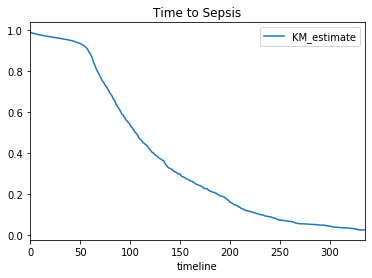

In [23]:
kmf.survival_function_.plot()
plt.title('Time to Sepsis')

In [24]:
kmf.median_survival_time_

106.0

In [25]:
test['Gender'].value_counts()

1    22566
0    17770
Name: Gender, dtype: int64

Text(0.5, 1.0, 'Sepsis Onset Males vs Femals')

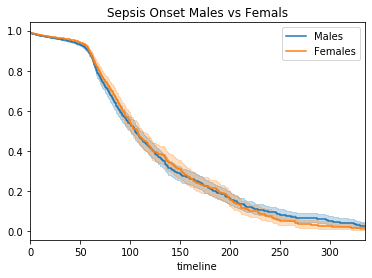

In [26]:
ax = plt.subplot(111)

Males = (test["Gender"] == 1)

kmf.fit(T[Males], event_observed=E[Males], label="Males")
kmf.plot(ax=ax)

kmf.fit(T[~Males], event_observed=E[~Males], label="Females")
kmf.plot(ax=ax)

plt.title("Sepsis Onset Males vs Femals")

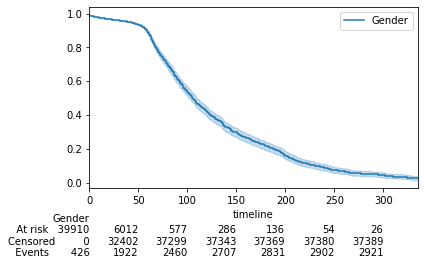

In [28]:
kmf = KaplanMeierFitter().fit(T, E, label="Gender")
kmf.plot(at_risk_counts=True)

In [30]:
from lifelines.statistics import logrank_test

results = logrank_test(T[Males], T[~Males], E[Males], E[~Males], alpha=.95)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           7.84 0.01      7.62

### Nelson Aalen Estimator
* surivial function $h(t)$

$
H(t) = \int_{0}^{t} \lambda (z) dz 
$

Estimator is 

$
\hat{H}(t) = \sum_{t_i \leq t} \frac{d_i}{n_i} 
$

In [35]:
T = test["Time"]
E = test["Onset"]

from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

naf.fit(T,event_observed=E)

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 40336 total observations, 37404 right-censored observations>

In [33]:
test.head()

,PID,Gender,Age,Time,Onset
0,p000001,0,83.14,53,0
1,p000002,0,75.91,22,0
2,p000003,0,45.82,47,0
3,p000004,0,65.71,28,0
4,p000005,1,28.09,47,0


          NA_estimate
timeline             
0.0          0.010617
1.0          0.012523
2.0          0.014207
3.0          0.015364
4.0          0.016699


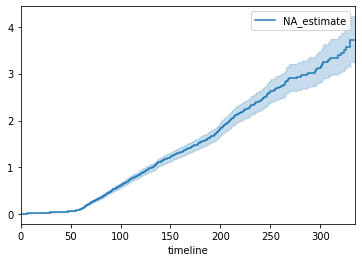

In [36]:
print(naf.cumulative_hazard_.head())
naf.plot()

### Weibull Model

$
S(t) = exp((-\frac{t}{\lambda})^\rho)
$

In [37]:
from lifelines import WeibullFitter
from lifelines.datasets import load_waltons

wf = WeibullFitter().fit(T, E)

wf.print_summary()
ax = wf.plot()
ax.set_title("Cumulative hazard of Weibull model; estimated parameters")

ValueError: This model does not allow for non-positive durations. Suggestion: add a small positive value to zero elements.

### Surival Regression
* https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html

In [19]:
from lifelines import CoxPHFitter

In [25]:
sepsis.iloc[:,2:-1].head()

,Delta_t_hours,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
5594,12,62.0,98.000000,37.0600,108.0,55.0,30.0,23.0,0.0,0.00,...,0.000000,0.0,0.000000,80,0,0.0,1.0,4.76,13,1
12096,28,95.0,94.000000,37.4450,0.0,94.0,0.0,26.0,0.0,3.75,...,13.300000,0.0,303.000000,32,1,0.0,0.0,0.03,29,1
15033,6,96.0,98.000000,36.5500,103.0,76.0,61.0,16.0,0.0,0.00,...,20.360000,0.0,179.600000,57,1,0.0,1.0,53.23,7,1
42031,15,71.0,98.166667,36.3000,116.0,68.0,54.0,14.5,0.0,0.00,...,3.722222,0.0,117.444444,69,0,0.0,0.0,6.54,16,0
3598,175,67.0,89.000000,37.0975,134.0,85.0,55.0,19.0,0.0,4.00,...,10.800000,0.0,170.000000,76,1,0.0,0.0,0.01,176,1


In [26]:
cph = CoxPHFitter()
cph.fit(sepsis.iloc[:,2:-1],
        duration_col='Delta_t_hours', 
        event_col='SepsisLabel',
       show_progress=True,step_size=.01)

Iteration 1: norm_delta = 2.01047, step_size = 0.0100, log_lik = -269088.89891, newton_decrement = 21764.93591, seconds_since_start = 0.2
Iteration 2: norm_delta = 1.90150, step_size = 0.0100, log_lik = -268655.78532, newton_decrement = 21091.72714, seconds_since_start = 0.3
Iteration 3: norm_delta = 1.80523, step_size = 0.0100, log_lik = -268236.06699, newton_decrement = 20477.63327, seconds_since_start = 0.4
Iteration 4: norm_delta = 1.69603, step_size = 0.0130, log_lik = -267707.12173, newton_decrement = 19752.39299, seconds_since_start = 0.6
Iteration 5: norm_delta = 1.57808, step_size = 0.0169, log_lik = -267045.15213, newton_decrement = 18918.70385, seconds_since_start = 0.7
Iteration 6: norm_delta = 1.45891, step_size = 0.0220, log_lik = -266223.02088, newton_decrement = 17990.99040, seconds_since_start = 0.9
Iteration 7: norm_delta = 1.34887, step_size = 0.0286, log_lik = -265210.02732, newton_decrement = 16996.10898, seconds_since_start = 1.0
Iteration 8: norm_delta = 1.25902,

/anaconda3/lib/python3.7/site-packages/lifelines/fitters/coxph_fitter.py:1270: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  "Newton-Rhaphson failed to converge sufficiently. {0}".format(CONVERGENCE_DOCS), exceptions.ConvergenceWarning


<lifelines.CoxPHFitter: fitted with 55832 total observations, 27916 right-censored observations>

In [27]:
cph.print_summary() 

<lifelines.CoxPHFitter: fitted with 55832 total observations, 27916 right-censored observations>
             duration col = 'Delta_t_hours'
                event col = 'SepsisLabel'
      baseline estimation = breslow
   number of observations = 55832
number of events observed = 27916
   partial log-likelihood = -223010.29
         time fit was run = 2020-09-28 00:26:06 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
HR                 0.00       1.00       0.00             0.00             0.01                 1.00                 1.01
O2Sat             -0.01       0.99       0.00            -0.02            -0.01                 0.99                 0.99
Temp              -0.03       0.97       0.00            -0.03            -0.03                 0.97                 0.97
SBP               -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
MAP                0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
DBP               -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Resp               0.00       1.00       0.00             0.00             0.01                 1.00                 1.01
EtCO2              0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
BaseExcess         0.01       1.01       0.00             0.00             0.01                 1.00                 1.01
HCO3              -0.00       1.00       0.00            -0.01            -0.00                 0.99                 1.00
FiO2               0.32       1.38       0.02             0.29             0.36                 1.33                 1.44
pH                 0.04       1.04       0.00             0.03             0.05                 1.03                 1.05
PaCO2             -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
SaO2              -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
AST               -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
BUN                0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
Alkalinephos       0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
Calcium           -0.01       0.99       0.00            -0.02            -0.01                 0.98                 0.99
Chloride           0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Creatinine         0.02       1.02       0.00             0.01             0.03                 1.01                 1.03
Bilirubin_direct   0.01       1.01       0.00            -0.00             0.02                 1.00                 1.02
Glucose           -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Lactate            0.01       1.02       0.00             0.01             0.02                 1.01                 1.02
Magnesium         -0.07       0.93       0.01            -0.10            -0.05                 0.91                 0.95
Phosphate          0.01       1.01       0.00             0.00             0.02                 1.00                 1.02
Potassium         -0.06       0.94       0.01            -0.08            -0.05                 0.92                 0.95
Bilirubin_total   -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
TroponinI          0.00       1.00       0.00            -0.00             0.00

In [65]:
cph.summary.sort_values('p')

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
ICULOS,-0.136838,0.872111,0.001008,-0.138814,-0.134862,0.870390,0.873836,-135.746070,0.000000e+00,inf
EtCO2,0.020159,1.020363,0.000608,0.018967,0.021350,1.019148,1.021580,33.149728,5.714629e-241,798.070011
HR,0.008897,1.008937,0.000290,0.008329,0.009464,1.008364,1.009509,30.722428,2.856157e-207,686.125040
Unit2,-0.336452,0.714300,0.016189,-0.368182,-0.304723,0.691991,0.737328,-20.782922,6.178165e-96,316.277919
SBP,-0.003742,0.996265,0.000204,-0.004142,-0.003342,0.995867,0.996664,-18.328870,4.869149e-75,246.860938
Resp,0.012284,1.012360,0.000875,0.010569,0.013999,1.010625,1.014097,14.037747,9.157806e-45,146.291762
pH,0.065414,1.067601,0.005708,0.054227,0.076601,1.055725,1.079611,11.460780,2.076366e-30,98.603782
Gender,0.130556,1.139462,0.012252,0.106543,0.154569,1.112426,1.167155,10.656149,1.632168e-26,85.663341
Lactate,0.056092,1.057696,0.006288,0.043769,0.068416,1.044741,1.070811,8.921134,4.615383e-19,60.910184


In [53]:
cph.predict_survival_function(sepsis.iloc[17,1:-2]).T

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,77.0,78.0,79.0,80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,89.0,90.0,91.0,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0,100.0,101.0,102.0,103.0,104.0,105.0,106.0,107.0,108.0,109.0,110.0,111.0,112.0,113.0,114.0,115.0,116.0,117.0,118.0,119.0,120.0,121.0,122.0,123.0,124.0,125.0,126.0,127.0,128.0,129.0,130.0,131.0,132.0,133.0,134.0,135.0,136.0,137.0,138.0,139.0,140.0,141.0,142.0,143.0,144.0,145.0,146.0,147.0,148.0,149.0,150.0,151.0,152.0,153.0,154.0,155.0,156.0,157.0,158.0,159.0,160.0,161.0,162.0,163.0,164.0,165.0,166.0,167.0,168.0,169.0,170.0,171.0,172.0,173.0,174.0,175.0,176.0,177.0,178.0,179.0,180.0,181.0,182.0,183.0,184.0,185.0,186.0,187.0,188.0,189.0,190.0,191.0,192.0,193.0,194.0,195.0,196.0,197.0,198.0,199.0,200.0,201.0,202.0,203.0,204.0,205.0,206.0,207.0,208.0,209.0,210.0,211.0,212.0,213.0,214.0,215.0,216.0,217.0,218.0,219.0,220.0,221.0,222.0,223.0,224.0,225.0,226.0,227.0,228.0,229.0,230.0,231.0,232.0,233.0,234.0,235.0,236.0,237.0,238.0,239.0,240.0,241.0,242.0,243.0,244.0,245.0,246.0,247.0,248.0,249.0,250.0,251.0,252.0,253.0,254.0,255.0,256.0,257.0,258.0,259.0,260.0,261.0,262.0,263.0,264.0,265.0,266.0,267.0,268.0,269.0,270.0,271.0,272.0,273.0,274.0,275.0,276.0,277.0,278.0,279.0,280.0,281.0,282.0,283.0,284.0,285.0,286.0,287.0,288.0,289.0,290.0,291.0,292.0,293.0,294.0,295.0,296.0,297.0,298.0,299.0,300.0,301.0,302.0,303.0,304.0,305.0,306.0,307.0,308.0,309.0,310.0,311.0,312.0,313.0,314.0,315.0,316.0,317.0,318.0,319.0,320.0,321.0,322.0,323.0,324.0,325.0,326.0,327.0,328.0,329.0,330.0,331.0,332.0,333.0,334.0,335.0
38053,0.989788,0.96953,0.941605,0.905904,0.861222,0.806295,0.742641,0.670204,0.610834,0.556495,0.505023,0.454574,0.405402,0.356486,0.311115,0.268352,0.228344,0.192477,0.159924,0.129983,0.103422,0.081521,0.063694,0.048309,0.03547,0.025425,0.017719,0.012036,0.00786,0.00499,0.002962,0.001643,0.000855,0.000417,0.000185,0.000074,0.000026,0.000008,0.000002,4.175453e-07,7.310568e-08,1.043925e-08,1.132951e-09,9.494575e-11,5.829571e-12,2.118588e-13,5.538471e-15,8.413767e-17,8.052439e-19,3.972741e-21,1.132318e-23,2.200094e-26,1.698769e-29,4.246593e-33,5.685220e-37,3.515415e-41,6.810973e-46,8.061033e-51,2.801155e-56,3.159441e-62,1.488420e-68,2.248211e-75,1.195308e-82,8.744332e-91,7.032464e-100,4.653041e-110,9.695732e-122,1.752157e-134,1.669221e-148,2.535744e-164,5.385907e-182,3.760893e-202,3.316069e-224,2.620615e-247,1.487305e-271,8.489996e-298,4.940656e-324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


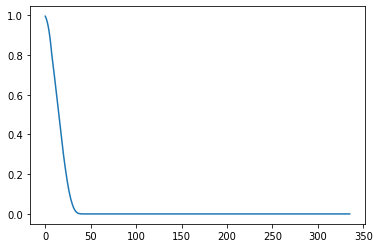

In [67]:
plt.plot(range(0,336),cph.predict_survival_function(sepsis.iloc[3460,1:-2]).values)


In [64]:
sepsis.iloc[3457,1:-2]

PatientID           p018361
Delta_t_hours            15
HR                      105
O2Sat                    98
Temp                  37.78
SBP                      98
MAP                   68.67
DBP                       0
Resp                     21
EtCO2                     0
BaseExcess                0
HCO3                21.9231
FiO2                    0.5
pH                        0
PaCO2                     0
SaO2                      0
AST                       0
BUN                 9.61538
Alkalinephos              0
Calcium                 8.1
Chloride            105.846
Creatinine              0.5
Bilirubin_direct          0
Glucose             94.3846
Lactate                   0
Magnesium           1.89231
Phosphate           3.17692
Potassium           3.91538
Bilirubin_total           0
TroponinI                 0
Hct                 33.6462
Hgb                 11.8462
PTT                       0
WBC                 8.15385
Fibrinogen                0
Platelets           

#come back to this after chopping up the time intervals